# **InceptionNet LC phase classifier**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [114]:
file_title = "InceptionNetLC-V6"

In [115]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import Model
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image_dataset_from_directory
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model
from keras.regularizers import l2

In [116]:
import sys
sys.path.insert(0,"/content/drive/MyDrive/")
from Model_metric_plotter_saver import plot_metrics, save_history_to_csv, confusion_matrix_plot

In [117]:
img_directory = "/content/drive/My Drive/I-N-Chol-Sm_dataset-balanced"

train_dir = img_directory + "/Train"
val_dir = img_directory + "/Val"

In [6]:
image_size=(256,256)
train_dataset = image_dataset_from_directory(train_dir,
                            labels="inferred",
                            label_mode="categorical",
                            color_mode="grayscale",
                            batch_size=64,
                            image_size=image_size,
                            shuffle=True
                        )
val_dataset = image_dataset_from_directory(val_dir,
                            labels="inferred",
                            label_mode="categorical",
                            color_mode="grayscale",
                            batch_size=64,
                            image_size=image_size,
                            shuffle=False
                        )

# These next steps enable the dataset to be stored in cache (if it can fit)
# meaning that after data is loaded in on the first epoch, it will
# be loaded in much faster
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Found 5859 files belonging to 4 classes.
Found 1546 files belonging to 4 classes.


In [54]:
def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):
    conv_1x1 = layers.Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)
    
    conv_3x3 = layers.Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_3x3 = layers.Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(conv_3x3)

    conv_5x5 = layers.Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_5x5 = layers.Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')(conv_5x5)

    pool_proj = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = layers.Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(pool_proj)

    output = layers.concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output

In [118]:
# Define model layers
# Input/preprocessing layers
input_layer = layers.Input(shape = (256,256,1), name="Input")
X = layers.experimental.preprocessing.Rescaling(1./255, name="Normalize")(input_layer)
X = layers.experimental.preprocessing.RandomFlip()(X)

# Conv layers
X = layers.Conv2D(16, kernel_size=(5,5), activation="relu", name="Conv1")(X)
X = layers.MaxPooling2D(2,2, name="MaxPool1")(X)

# Inception layers
X = inception_module(X,
                     filters_1x1=64,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=32,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='Inception2')

X = inception_module(X,
                     filters_1x1=64,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=32,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='Inception3')

# Fully connected layers
X = layers.GlobalAveragePooling2D()(X)
X = layers.Dense(units=128, activation="relu", name="FC4")(X)
X = layers.Dropout(0.5)(X)

# Output layer
X = layers.Dense(units=4, activation="softmax")(X)

Model: "InceptionNetLC-V6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
Normalize (Rescaling)           (None, 256, 256, 1)  0           Input[0][0]                      
__________________________________________________________________________________________________
random_flip_8 (RandomFlip)      (None, 256, 256, 1)  0           Normalize[0][0]                  
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 252, 252, 16) 416         random_flip_8[0][0]              
__________________________________________________________________________________

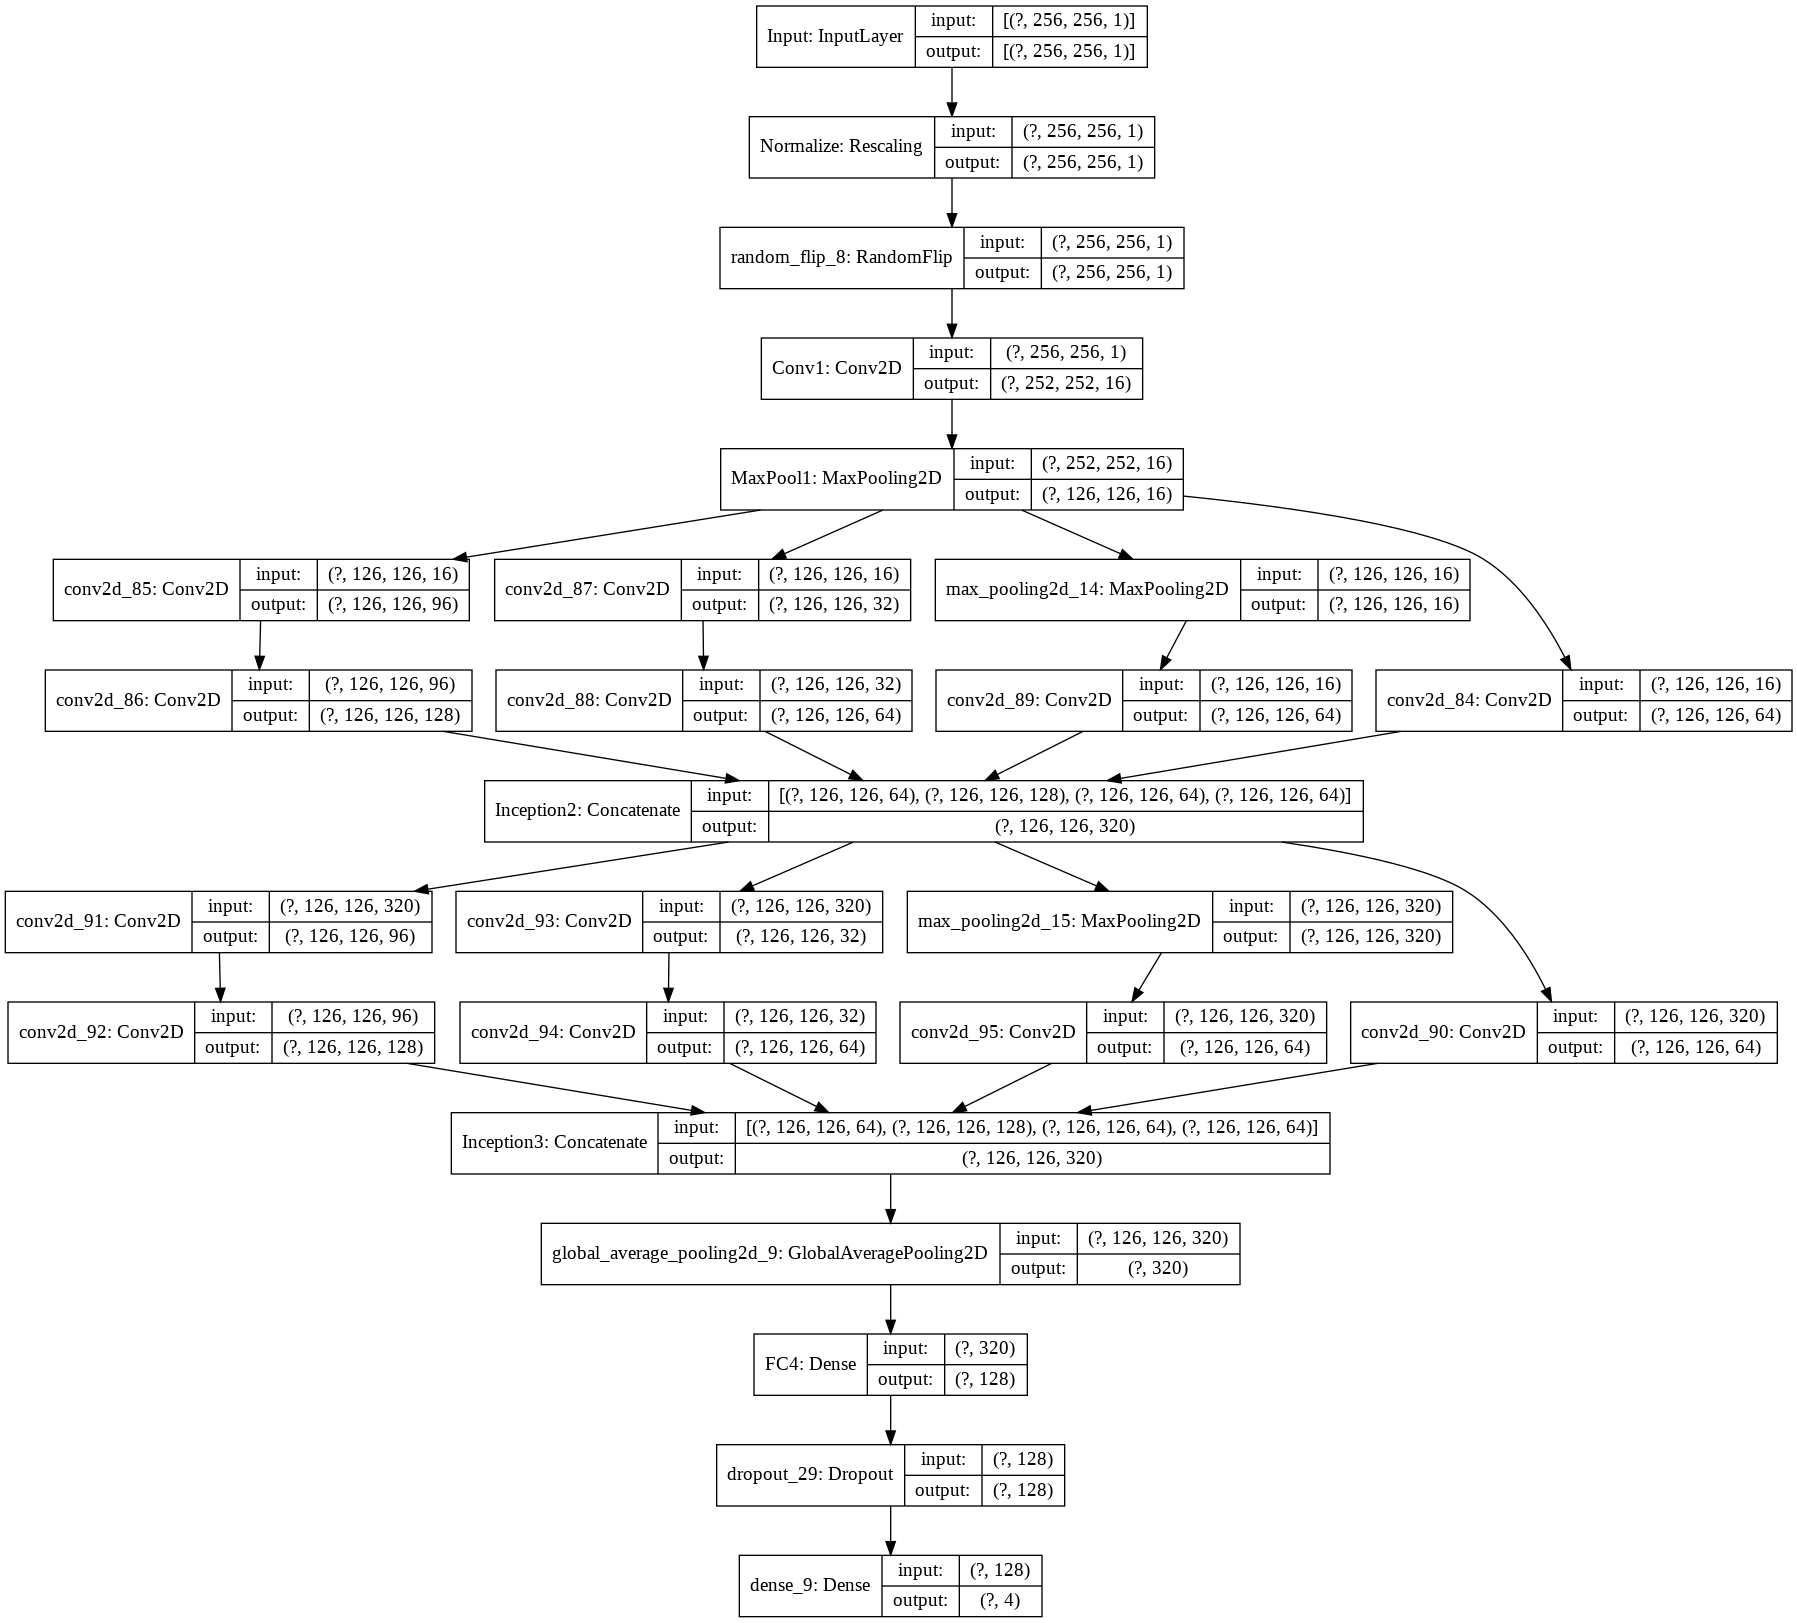

In [120]:
model = Model(input_layer, X, name=file_title)
model.summary()
model_save_path = "/content/drive/My Drive/" + file_title + ".png"
plot_model(model, to_file=model_save_path, show_shapes=True, show_layer_names=True)

In [121]:
metrics = ["accuracy"]

In [122]:
model_save_dir = "/content/drive/My Drive/" + file_title + "_saved_model"

In [123]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
checkpoint = ModelCheckpoint(model_save_dir, monitor = "val_accuracy", save_best_only = True, mode="max")
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=60,
                    callbacks=[checkpoint],
                    verbose=1
                   )

Epoch 1/60
92/92 [==============================] - 92s 1000ms/step - loss: 0.9384 - accuracy: 0.5433 - val_loss: 0.7435 - val_accuracy: 0.6345
Epoch 2/60
92/92 [==============================] - 91s 986ms/step - loss: 0.6344 - accuracy: 0.6960 - val_loss: 0.7041 - val_accuracy: 0.6313
Epoch 3/60
92/92 [==============================] - 93s 1s/step - loss: 0.5070 - accuracy: 0.7870 - val_loss: 0.6390 - val_accuracy: 0.7270
Epoch 4/60
92/92 [==============================] - 93s 1s/step - loss: 0.4404 - accuracy: 0.8111 - val_loss: 0.5490 - val_accuracy: 0.7904
Epoch 5/60
92/92 [==============================] - 93s 1s/step - loss: 0.3845 - accuracy: 0.8302 - val_loss: 0.4823 - val_accuracy: 0.8131
Epoch 6/60
92/92 [==============================] - 91s 986ms/step - loss: 0.3489 - accuracy: 0.8450 - val_loss: 0.5249 - val_accuracy: 0.7671
Epoch 7/60
92/92 [==============================] - 91s 986ms/step - loss: 0.3439 - accuracy: 0.8522 - val_loss: 0.4685 - val_accuracy: 0.8085
Epoch 8

In [124]:
save_dir = "/content/drive/My Drive/" + file_title

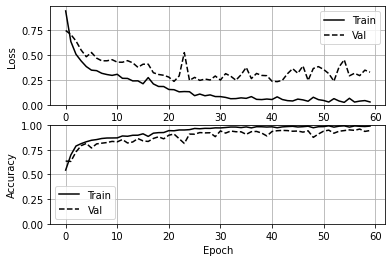

In [125]:
metrics = ["loss", "accuracy"]
# Plot the training history of the model and save
training_plot_save_path = save_dir + "_training_history"
plot_metrics(history, training_plot_save_path, metrics)

In [126]:
# Save training history to csv
csv_data_save_path = save_dir + "_training_history.csv"
save_history_to_csv(history, csv_data_save_path, metrics)

25/25 [==============================] - 6s 252ms/step


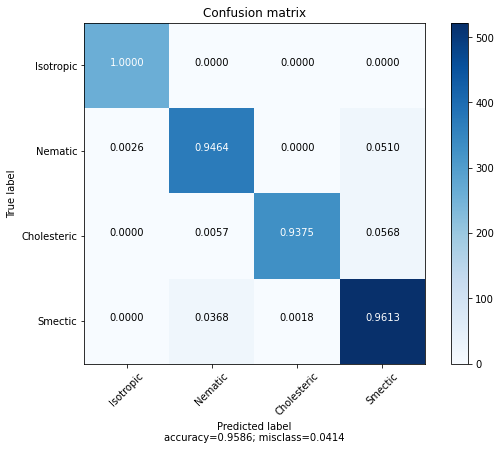

In [127]:
# Evaluate model on validation data and save the confusion matrix
# Get best saved model
trained_model = tf.keras.models.load_model(model_save_dir)
# Get predictions and true labels
predictions = trained_model.predict(val_dataset, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(np.concatenate([label for image, label in val_dataset], axis=0), axis=1)
# Plot and save the confusion matrix
target_names = ["Isotropic", "Nematic", "Cholesteric", "Smectic"]
confusion_mat_save_dir = save_dir + "_confusion_matrix"
confusion_matrix_plot(y_true, y_pred, target_names,
                      save=True, save_path=confusion_mat_save_dir)

# Applying the trained model to test videos

In [1]:
from lc_video_phase_labeller import PhaseLabeller

In [116]:
model_load_dir = "C:/Users/Jason/Documents/University/Year_4/MPhys_project/Project_work/Data/I-N-Chol-Sm_dataset-balanced/Results/InceptionNets/InceptionNetLC-V6/InceptionNetLC-V6_saved_model/"
phase_list = ["Isotropic", "Nematic", "Cholesteric", "Smectic"]
vid_file = "N-I/"
vid_name = "nematic 5cb on glycerol-2-Yellow_35.6C_cooling"
vid_path = "C:/Users/Jason/Documents/University/Year_4/MPhys_project/Project_work/Data/I-N-Chol-Sm-Crystal_dataset/Test_videos/" + vid_file + vid_name + ".avi"
save_dir = "C:/Users/Jason/Documents/University/Year_4/MPhys_project/Project_work/Data/I-N-Chol-Sm_dataset-balanced/Results/InceptionNets/InceptionNetLC-V6/Labelled_test_videos/"
vid_save_path = save_dir + vid_name + "_labelled.avi" 
start_temp = 35.6
end_temp = None
temp_rate = 0.1

In [117]:
phase_vid_labeller = PhaseLabeller()
phase_vid_labeller.get_model(model_load_dir, phase_list)

Model: "InceptionNetLC-V6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
Normalize (Rescaling)           (None, 256, 256, 1)  0           Input[0][0]                      
__________________________________________________________________________________________________
random_flip_8 (RandomFlip)      (None, 256, 256, 1)  0           Normalize[0][0]                  
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 252, 252, 16) 416         random_flip_8[0][0]              
__________________________________________________________________________________

In [118]:
phase_vid_labeller.label_video(vid_path,
                               vid_save_path,
                               start_temp,
                               end_temp=end_temp,
                               temp_rate_per_sec=temp_rate)

In [119]:
save_path = save_dir + vid_name + ".csv"
phase_vid_labeller.to_csv(save_path)

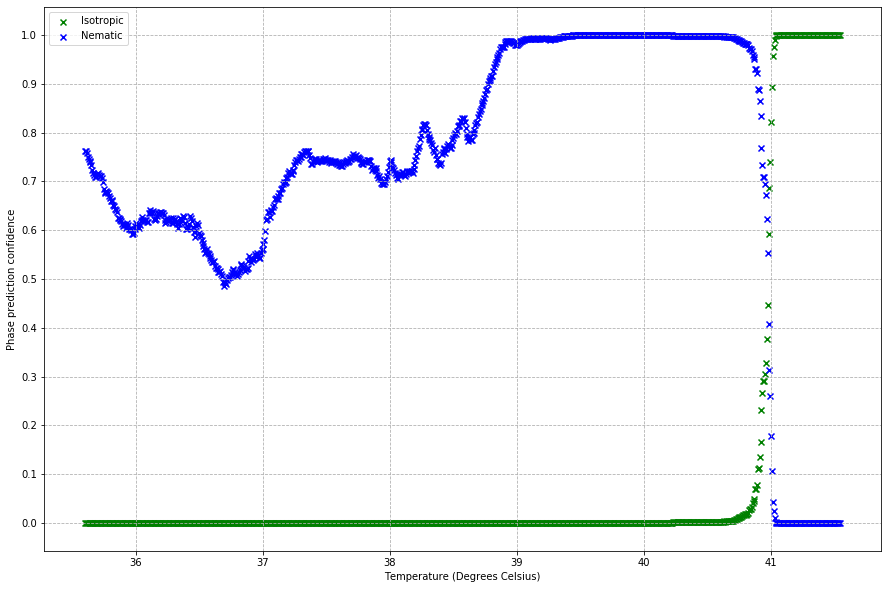

In [120]:
save_path = save_dir + vid_name + ".png"
#phase_plot_list = ["Isotropic", "Nematic", "Cholesteric", "Smectic"]
phase_plot_list = ["Isotropic", "Nematic"]
#color_list = ["g", "b", "r", "k"]
color_list = ["g", "b"]
phase_vid_labeller.conf_temp_plot(phase_plot_list,
                                  color_list,
                                  save_path)

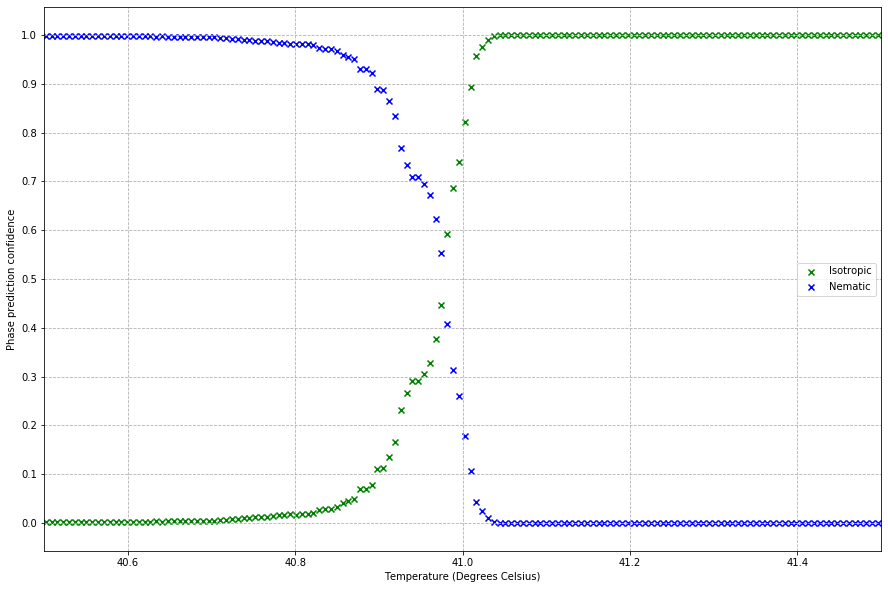

In [122]:
save_path = save_dir + vid_name + "-zoomed_in.png"
phase_vid_labeller.conf_temp_plot(phase_plot_list,
                                  color_list,
                                  save_path,
                                  start_temp=40.5,
                                  end_temp=41.5)